In [1]:
import itertools
from itertools import product
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
df_laptop = pd.read_csv('./data/processed_laptop_data.csv')

X = df_laptop.drop(columns= ['Price (Rs)'])
# y = np.log(df_laptop['Price (Rs)'])
y = np.log(df_laptop['Price (Rs)'].values) # Using the natural log of the price as the target variable

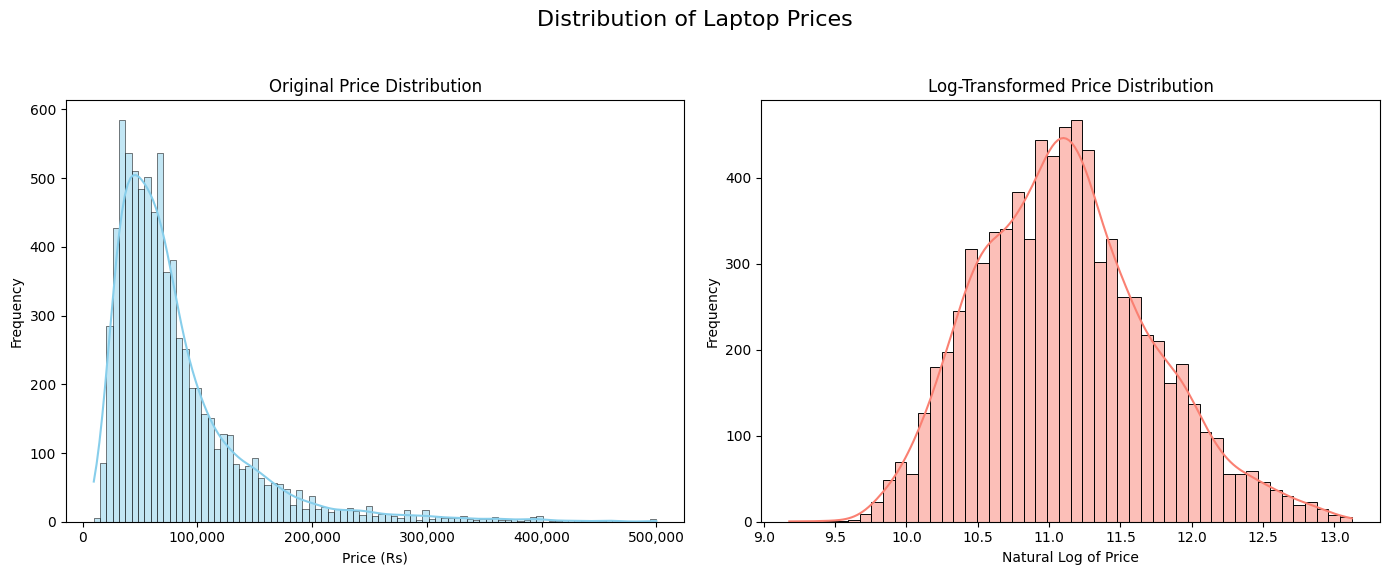

In [4]:
# Figure with 1 row, 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize = (14, 6))
fig.suptitle('Distribution of Laptop Prices', fontsize = 16)

sns.histplot(df_laptop['Price (Rs)'], kde = True, ax = axes[0], color = 'skyblue')
axes[0].set_title('Original Price Distribution')
axes[0].set_xlabel('Price (Rs)')
axes[0].set_ylabel('Frequency')
axes[0].get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)

sns.histplot(y, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Log-Transformed Price Distribution')
axes[1].set_xlabel('Natural Log of Price')
axes[1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

In [5]:
# Split data into train (80%) and test (20%)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

In [6]:
cat_col = ['Brand', 'Series', 'Graphic Processor', 'RAM Type', 'OS', 'Processor_Brand', 'Processor_Series']
num_col = [col for col in X_train_val.columns if col not in cat_col]

Model: Linear Regression

In [7]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore'), cat_col),
    ('num', StandardScaler(), num_col)
],remainder='passthrough')

step2 = LinearRegression()

pipe_lr = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe_lr.fit(X_train_val,y_train_val)

y_pred = pipe_lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

RMSE: 0.21802427112031839
R2 score 0.8671240728804723
MAE 0.14827210265794094


Model: Support Vector Regression (SVR)

In [8]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore'), cat_col),
    ('num', RobustScaler(), num_col)
],remainder='passthrough')

step2 = SVR(kernel='rbf',C=10000,epsilon=0.1)

pipe_svr = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe_svr.fit(X_train_val,y_train_val)

y_pred = pipe_svr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

RMSE: 0.3090954035133928
R2 score 0.7329320856374506
MAE 0.19951836172291465


In [9]:
svr_step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_col),
    ('num', RobustScaler(), num_col)
], remainder='passthrough')

svr_step2 = SVR(kernel='rbf')

pipe_svr = Pipeline([
    ('step1', svr_step1),
    ('step2', svr_step2)
])

param_grid = {
    'step2__C': [100, 1000, 10000],
    'step2__epsilon': [0.01, 0.1, 0.5],
    'step2__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(pipe_svr, 
                          param_grid, 
                          cv=2,  
                          scoring='r2',
                          n_jobs=-1,
                          verbose=1)

print("\nPerforming grid search...")
grid_search.fit(X_train_val, y_train_val)

best_svr = grid_search.best_estimator_

y_pred = best_svr.predict(X_test)
print('\nSVR Validation Scores (after tuning):')
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)
print('R2 score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))




Performing grid search...
Fitting 2 folds for each of 18 candidates, totalling 36 fits

SVR Validation Scores (after tuning):
RMSE: 0.18569281753525238
R2 score: 0.9036111424208609
MAE: 0.1297239195136022


In [10]:
input_df = pd.DataFrame([{
    'Brand': 'HP',
    'Series': 'pavilion',
    'Weight': 1.50,
    'Display Size': 14.0,
    'Pixel Density': 157.0,
    'Display Touchscreen': 0,
    'Graphic Processor': 'intel uhd',
    'RAM Capacity': 8,
    'RAM Type': 'ddr4',
    'SSD Capacity': 512,
    'OS': 'win 11',
    'Processor_Brand': 'intel',
    'Processor_Series': 'i3',
    'Graphics Memory': 0
}])

In [11]:
model_dict = {
    "Linear Regression": pipe_lr,
    "SVR": best_svr 
}

for name, model in model_dict.items():
    p = model.predict(input_df)
    predicted_price = np.exp(p[0])
    print(f"{name:25}: ₹ {predicted_price:,.2f}")

Linear Regression        : ₹ 42,944.37
SVR                      : ₹ 44,602.94


Model: Feedforward Neural Network

In [12]:
def preprocess_data(X, y=None, scaler=None, encoders=None, fit_transform=True):
    X_processed = X.copy()

    if scaler is None:
        scaler = StandardScaler()
    if encoders is None:
        encoders = {}

    categorical_cols = X_processed.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()


    # Handling categorical variables with One-Hot Encoding
    if categorical_cols:
        if fit_transform:
            ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            categorical_encoded = ohe.fit_transform(X_processed[categorical_cols])
            encoders['onehot'] = ohe
            encoders['categorical_cols'] = categorical_cols
        else:
            # Transform using existing encoder
            ohe = encoders['onehot']
            categorical_encoded = ohe.transform(X_processed[categorical_cols])
    else:
        categorical_encoded = np.array([]).reshape(len(X_processed), 0)

    # Handling numerical variables
    if numerical_cols:
        if fit_transform:
            numerical_scaled = scaler.fit_transform(X_processed[numerical_cols])
        else:
            numerical_scaled = scaler.transform(X_processed[numerical_cols])
    else:
        numerical_scaled = np.array([]).reshape(len(X_processed), 0)

    X_final = np.column_stack([numerical_scaled, categorical_encoded])
    return X_final, scaler, encoders

In [13]:
def create_model(input_dim, hidden_layers, neurons, dropout_rate, learning_rate):
    model = keras.Sequential()

    # Input layer
    model.add(layers.Dense(neurons, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(dropout_rate))

    # Hidden layers
    for _ in range(hidden_layers - 1):
        model.add(layers.Dense(neurons, activation='relu'))
        model.add(layers.Dropout(dropout_rate))

    # Output layer (regression - no activation)
    model.add(layers.Dense(1, activation='linear'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [14]:
def calculate_metrics(y_true, y_pred):
    """
    Calculates evaluation metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

In [15]:
def k_fold_cross_validation(X, y, params, k=5):
    """
    For hyperparameter tuning
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Splitting data into training and validation sets
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model = create_model(
            input_dim=X.shape[1],
            hidden_layers=params['hidden_layers'],
            neurons=params['neurons'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )

        # Early stopping callback because of the size of the dataset and preventing overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )

        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=100,
            batch_size=params['batch_size'],
            callbacks=[early_stopping],
            verbose=0
        )

        # Predict and calculate metrics
        y_pred = model.predict(X_val_fold, verbose=0)
        metrics = calculate_metrics(y_val_fold, y_pred)
        fold_scores.append(metrics['RMSE'])  # Using RMSE (of logs) as primary metric for HPO

    return np.mean(fold_scores)

In [16]:
def hyperparameter_tuning(X_train_val, y_train_val):
    """
    Perform HPO using k-fold cross-validation
    """

    param_grid = {
    'hidden_layers': [2],
    'neurons': [128, 256],
    'dropout_rate': [0.3],
    'learning_rate': [0.001],
    'batch_size': [64]
    }

    total_combinations = np.prod([len(v) for v in param_grid.values()])
    print(f"Total combinations to test: {total_combinations}")
    print("=" * 50)

    best_score = float('inf')
    best_params = None

    # Grid search (with k-fold CV)
    for i, params in enumerate(product(*param_grid.values())):
        param_dict = dict(zip(param_grid.keys(), params))

        print(f"\n[{i+1}/{total_combinations}] Testing: {param_dict}")
        start_time = time.time()

        cv_score = k_fold_cross_validation(X_train_val, y_train_val, param_dict, k=5)

        end_time = time.time()
        duration = end_time - start_time

        print(f"Result: RMSE of Logs = {cv_score:.4f} (took {duration:.1f} seconds)")

        if cv_score < best_score:
            best_score = cv_score
            best_params = param_dict
            print(f"      New best!!! RMSE of Logs = {best_score:.4f}")

        # Progress update
        progress = (i + 1) / total_combinations * 100
        print(f"      Progress: {progress:.1f}% complete")

    print("\n" + "=" * 50)
    print(f"Final HPO results:")
    print(f"Best hyperparameters: {best_params}")
    print(f"Best CV RMSE (of Logs): {best_score:.4f}")

    return best_params, best_score

In [17]:
def train_final_model(X_train_val, y_train_val, best_params):
    # Extracting parameters for model creation
    model_params = {
        'hidden_layers': best_params['hidden_layers'],
        'neurons': best_params['neurons'],
        'dropout_rate': best_params['dropout_rate'],
        'learning_rate': best_params['learning_rate']
    }

    model = create_model(
        input_dim=X_train_val.shape[1],
        **model_params
    )

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='loss', patience=15, restore_best_weights=True
    )

    # Note: Final model trained on the entire "train_val" set
    history = model.fit(
        X_train_val, y_train_val,
        epochs=200,
        batch_size=best_params['batch_size'],
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history

In [18]:
def evaluate_model(model, X_test, y_test_log):
    """
    Evaluating the final model on the test set
    """
    # Predictions on the log scale of prices
    y_pred_log = model.predict(X_test, verbose=0)

    y_pred_original = np.exp(y_pred_log)
    y_test_original = np.exp(y_test_log)

    metrics = calculate_metrics(y_test_original, y_pred_original)  # calculated on the original price scale

    print("\n" + "="*50)
    print("Final Model Evaluation on test set! (in original price scale)")
    print("="*50)
    print(f"RMSE: {metrics['RMSE']:.4f} (in Rs)")
    print(f"MAE:  {metrics['MAE']:.4f} (in Rs)")
    print(f"R²:   {metrics['R2']:.4f}")
    print("="*50)

    return metrics, y_pred_original

In [19]:
def plot_training_history(history):
    """
    Plot training history: Loss and MAE on log-transformed data
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss (on Log-Transformed Price)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['mae'], label='Training MAE')
    plt.title('Model MAE (on Log-Transformed Price)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [20]:
def plot_predictions(y_true, y_pred):
    """
    Plots scatterplot between actual vs predicted values (on the original price scale)
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Price (Rs)')
    plt.ylabel('Predicted Price (Rs)')
    plt.title('Actual vs Predicted Laptop Prices (Original Scale)')
    plt.grid(True, alpha=0.3)
    plt.show()

In [21]:
# Scaling and encoding the data
X_train_val_processed, scaler, encoders = preprocess_data(
    X_train_val, fit_transform=True
)
X_test_processed, _, _ = preprocess_data(
    X_test, scaler=scaler, encoders=encoders, fit_transform=False
)

In [22]:
best_params, best_score = hyperparameter_tuning(X_train_val_processed, y_train_val)

Total combinations to test: 2

[1/2] Testing: {'hidden_layers': 2, 'neurons': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}
Result: RMSE of Logs = 0.3004 (took 140.5 seconds)
      New best!!! RMSE of Logs = 0.3004
      Progress: 50.0% complete

[2/2] Testing: {'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}
Result: RMSE of Logs = 0.3325 (took 142.3 seconds)
      Progress: 100.0% complete

Final HPO results:
Best hyperparameters: {'hidden_layers': 2, 'neurons': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}
Best CV RMSE (of Logs): 0.3004


In [23]:
# Train final model
final_model, history = train_final_model(X_train_val_processed, y_train_val, best_params)

Epoch 1/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 61.7234 - mae: 6.7983
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4615 - mae: 1.2107
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9672 - mae: 1.1027
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7799 - mae: 1.0592
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5621 - mae: 0.9987
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5442 - mae: 0.9959
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4968 - mae: 0.9748
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4134 - mae: 0.9458
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3709 - mae: 0.9307
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3409 - mae: 0.9291
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3395 - mae: 0.9238
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3020 - mae: 0.9097
Epoch 13/200
98/98 ━━━━━━━━━━━━━━━━━

In [24]:
# Evaluating on test set
metrics, y_pred_original = evaluate_model(final_model, X_test_processed, y_test)


Final Model Evaluation on test set! (in original price scale)
RMSE: 22740.9706 (in Rs)
MAE:  12228.9158 (in Rs)
R²:   0.8436


Visualizing Results for FFNN

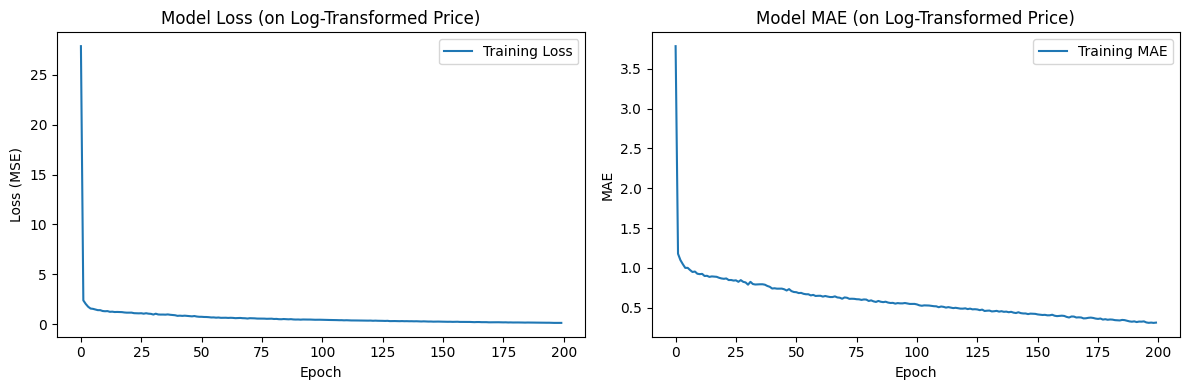

In [25]:
plot_training_history(history.history)

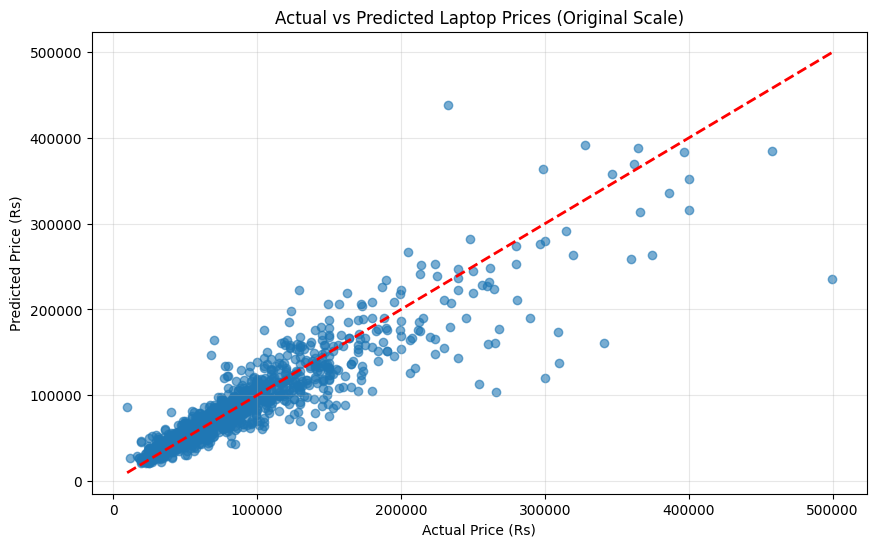

In [26]:
plot_predictions(np.exp(y_test), y_pred_original.flatten())